In [42]:
import time
from rouge_score import rouge_scorer
import pandas as pd
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline,AutoModelForSeq2SeqLM,BitsAndBytesConfig
from sentence_transformers import SentenceTransformer,util
from huggingface_hub import InferenceClient
import faiss
from ollama import Client
import nltk
nltk.download('punkt')
ollama_client = Client()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
cuda = "cuda" if torch.cuda.is_available() else "cpu"
cuda

'cuda'

In [44]:
df = pd.read_excel("data/data.xlsx")
cat_df = pd.read_csv("data/amazon_categories.csv")
cat_df.head()

,id,category_name,discount
0,1,Beading & Jewelry Making,30
1,2,Fabric Decorating,15
2,3,Knitting & Crochet Supplies,40
3,4,Printmaking Supplies,20
4,5,Scrapbooking & Stamping Supplies,30


In [45]:
print("Product dataset columns:", df.columns.tolist())
print("Category dataset columns:", cat_df.columns.tolist())

Product dataset columns: ['asin', 'title', 'imgUrl', 'productURL', 'stars', 'reviews', 'price', 'listPrice', 'category_id', 'isBestSeller', 'boughtInLastMonth']
Category dataset columns: ['id', 'category_name', 'discount']


In [46]:
df = df.merge(cat_df, left_on="category_id", right_on="id", how="left")
df.head()

,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,id,category_name,discount
0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.5,0,139.99,0.00,104,False,2000,104,Suitcases,20
1,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,https://m.media-amazon.com/images/I/81bQlm7vf6...,https://www.amazon.com/dp/B07GDLCQXV,4.5,0,169.99,209.99,104,False,1000,104,Suitcases,20
2,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,https://m.media-amazon.com/images/I/71EA35zvJB...,https://www.amazon.com/dp/B07XSCCZYG,4.6,0,365.49,429.99,104,False,300,104,Suitcases,20
3,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,https://m.media-amazon.com/images/I/91k6NYLQyI...,https://www.amazon.com/dp/B08MVFKGJM,4.6,0,291.59,354.37,104,False,400,104,Suitcases,20
4,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,https://m.media-amazon.com/images/I/61NJoaZcP9...,https://www.amazon.com/dp/B01DJLKZBA,4.5,0,174.99,309.99,104,False,400,104,Suitcases,20


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10163 entries, 0 to 10162
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   asin               10163 non-null  object 
 1   title              10163 non-null  object 
 2   imgUrl             10163 non-null  object 
 3   productURL         10163 non-null  object 
 4   stars              10163 non-null  float64
 5   reviews            10163 non-null  int64  
 6   price              10163 non-null  float64
 7   listPrice          10163 non-null  float64
 8   category_id        10163 non-null  int64  
 9   isBestSeller       10163 non-null  bool   
 10  boughtInLastMonth  10163 non-null  int64  
 11  id                 10163 non-null  int64  
 12  category_name      10163 non-null  object 
 13  discount           10163 non-null  int64  
dtypes: bool(1), float64(3), int64(5), object(5)
memory usage: 1.0+ MB


In [48]:
df.isnull().sum()

asin                 0
title                0
imgUrl               0
productURL           0
stars                0
reviews              0
price                0
listPrice            0
category_id          0
isBestSeller         0
boughtInLastMonth    0
id                   0
category_name        0
discount             0
dtype: int64

In [49]:
df = df.dropna()
df["price"] = df["price"].replace("$","",regex=True).astype(float)
df = df[df['price'] > 0]
df.head()

,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,id,category_name,discount
0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.5,0,139.99,0.00,104,False,2000,104,Suitcases,20
1,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,https://m.media-amazon.com/images/I/81bQlm7vf6...,https://www.amazon.com/dp/B07GDLCQXV,4.5,0,169.99,209.99,104,False,1000,104,Suitcases,20
2,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,https://m.media-amazon.com/images/I/71EA35zvJB...,https://www.amazon.com/dp/B07XSCCZYG,4.6,0,365.49,429.99,104,False,300,104,Suitcases,20
3,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,https://m.media-amazon.com/images/I/91k6NYLQyI...,https://www.amazon.com/dp/B08MVFKGJM,4.6,0,291.59,354.37,104,False,400,104,Suitcases,20
4,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,https://m.media-amazon.com/images/I/61NJoaZcP9...,https://www.amazon.com/dp/B01DJLKZBA,4.5,0,174.99,309.99,104,False,400,104,Suitcases,20


In [50]:
df = df.merge(cat_df, left_on="category_id", right_on="id", how="left")

In [51]:
df.head(1)

,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,id_x,category_name_x,discount_x,id_y,category_name_y,discount_y
0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.5,0,139.99,0.0,104,False,2000,104,Suitcases,20,104,Suitcases,20


In [52]:
df['short_text'] = (
    df['title'].astype(str) + " | Category: " + df['category_name_x'].astype(str)
)


In [53]:
df['text'] = (
    "Title: " + df['title'].astype(str) +
    " | Category: " + df['category_name_y'].astype(str) +
    " | Price: $" + df['price'].astype(str) +
    " | List Price: $" + df['listPrice'].astype(str) +
    " | Rating: " + df['stars'].astype(str) +
    " | Reviews: " + df['reviews'].astype(str) +
    " | Best Seller: " + df['isBestSeller'].astype(str) +
    " | Bought Last Month: " + df['boughtInLastMonth'].astype(str) +
    " | Product URL: " + df['productURL'].astype(str) +
    " | Image URL: " + df['imgUrl'].astype(str)
)


# Embedding model

In [13]:
embed_model = SentenceTransformer()
embed_model = SentenceTransformer('all-MiniLM-l6-v2')
print(embed_model)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [14]:
# genereating enbeddings
embeddings = embed_model.encode(df['text'].tolist(), convert_to_numpy=True,show_progress_bar=True).astype('float32')

Batches: 100%|██████████| 312/312 [00:09<00:00, 32.10it/s]


In [15]:
print("embeddings shape:", embeddings.shape)

embeddings shape: (9976, 384)


In [16]:
# Faiss database

dim = embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(embeddings)

print("Number of products in index:", index.ntotal)

Number of products in index: 9976


In [17]:
def search_product(query, k=5):
  # Converint query to embedding
  query_vec = embed_model.encode([query]).astype('float32')

  distances, indixes = index.search(query_vec, k)

  return df.iloc[indixes[0]]

In [18]:
results = search_product("Give me suitcase under $100")
results[['title', 'category_name_y', 'price', 'stars', 'reviews', 'productURL']]


,title,category_name_y,price,stars,reviews,productURL
124,"20 Inch suitcase, Travel Case, User-Friendly F...",Suitcases,159.00,0.0,0,https://www.amazon.com/dp/B0C6J52B9G
676,"Suitcase, Peony, XL (75 cm-94 L)",Suitcases,500.35,4.5,0,https://www.amazon.com/dp/B079ZJN5WJ
672,365 Roller 75l,Suitcases,153.75,4.1,0,https://www.amazon.com/dp/B09VRKZQ98
38,"Elegance Carry On Suitcase, 20â€ Hardside Lug...",Suitcases,199.99,4.4,0,https://www.amazon.com/dp/B07YD3VZCG
530,"Suitcase, Graphite, 55 cm",Suitcases,110.20,4.6,0,https://www.amazon.com/dp/B01N4ESLFO


In [19]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# =========================
# Model 1: Flan-T5-Large (main)
# =========================
model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name

)

# =========================s
# Model 2: Flan-T5-Base (medium)
# =========================
model2_name = "microsoft/phi-2"
tokenizer2 = AutoTokenizer.from_pretrained(model2_name)
model2 = AutoModelForCausalLM.from_pretrained(
    model2_name
)

# =========================
# Model 3: Flan-T5-Small (fastest, fallback)
# =========================
model3_name = "google/flan-t5-small"
tokenizer3 = AutoTokenizer.from_pretrained(model3_name)
model3 = AutoModelForSeq2SeqLM.from_pretrained(model3_name)


Loading checkpoint shards: 100%|██████████| 2/2 [00:26<00:00, 13.11s/it]


In [20]:
def run_model(model, tokenizer, prompt, max_new_tokens=100):
    device = next(model.parameters()).device if hasattr(model, "parameters") else "cpu"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

In [21]:
SYSTEM_PROMPT = """
You are a product recommendation assistant. 
Here are the products with all their details (title, category, price, list price, rating, reviews, best seller status, bought last month):

{retrieved_texts}

Question: {user_query}
Answer in **one sentence**. Use the product name and any relevant details from the data to answer, such as price, rating, reviews, or best seller status.
"""


In [28]:
# def build_rag_prompt(user_query, retrieved_texts):
#     if isinstance(retrieved_texts, str):
#         retrieved_texts_joined = retrieved_texts
#     elif isinstance(retrieved_texts, list):
#         retrieved_texts_joined = "\n---\n".join(retrieved_texts)
#     else:
#         raise ValueError("retrieved_texts must be string or list")

#     prompt = SYSTEM_PROMPT.replace("{{retrieved_texts}}", retrieved_texts_joined)
#     prompt = prompt.replace("{{user_query}}", user_query)
#     return prompt

def build_rag_prompt(user_query, retrieved_texts):
    """
    General text-only prompt for product recommendation.
    Returns a single product recommendation in one sentence.
    Works for all models.
    """
    if isinstance(retrieved_texts, list):
        retrieved_texts = "\n".join(retrieved_texts)
    
    prompt = f"""
You are a helpful product recommendation assistant.

Here are the available products with all details (title, category, price, rating, reviews, best seller status, bought last month):

{retrieved_texts}

Question: {user_query}

Instructions:
- Pick **only one product** from the list that best matches the question.
- Provide the answer in **one sentence**.
- Include the product **name** and any key details (price, rating, or features) that make it relevant.
- Do not list or summarize multiple products.
- Make the answer clear and concise.
"""
    return prompt



In [29]:
def build_rag_prompt_json_large(user_query, retrieved_texts):
    if isinstance(retrieved_texts, list):
        retrieved_texts = "\n".join(retrieved_texts)

    prompt = f"""
You are a product recommendation assistant.  
Return ONLY valid JSON. No extra text.  

Here are the retrieved products with full details:

{retrieved_texts}

User Question: {user_query}

Your JSON response MUST follow this exact structure:

{{
  "products": [
    {{
      "title": "",
      "category": "",
      "price": "",
      "rating": "",
      "reviews": "",
      "best_seller": "",
      "bought_last_month": ""
    }}
  ],
  "recommendation": "",
  "reason": ""
}}

Rules:
- Fill each field using EXACT data from the product list above.
- Add as many products as needed in the "products" array.
- For "recommendation", choose the best matching product for the question.
- For "reason", explain briefly why it is the best.
- Output ONLY JSON.
"""
    return prompt
  
  
def build_rag_propmt_json_small(user_query, retrived_texts):
  if isinstance(retrived_texts, list):
    retrived_texts = "\n".join(retrived_texts)
    
  prompt = f"""
  Return ONLY JSON.

Products: {retrived_texts}
User Question: {user_query}

JSON format:

{{
  "products": [],
  "recommendation": "",
  "reason": ""
}}
"""


In [30]:
def format_products_for_llm(df):
    lines = []
    for _, row in df.iterrows():
        line = (
            f"Title: {row['title']} | "
            f"Category: {row['category_name_x']} | "
            f"Price: {row['price']} | "
            f"Rating: {row['stars']} | "
            f"Reviews: {row['reviews']} | "
            f"BestSeller: {row['isBestSeller']} | "
            f"BoughtLastMonth: {row['boughtInLastMonth']}"
        )
        lines.append(line)
    return "\n".join(lines)


def format_products_for_llm_short(df):
    formatted_products = []
    short_form_products = []
    for _, row in df.iterrows():
        # Full detail for large model
        line = (
            f"Title: {row['title']} | "
            f"Category: {row['category_name_x']} | "
            f"Price: {row['price']} | "
            f"Rating: {row['stars']} | "
            f"Reviews: {row['reviews']} | "
            f"BestSeller: {row['isBestSeller']} | "
            f"BoughtLastMonth: {row['boughtInLastMonth']}"
        )
        formatted_products.append(line)

        # Short summary for base and small models
        short_line = f"{row['title']} (${row['price']}, {row['stars']}★, bought {row['boughtInLastMonth']})"
        short_form_products.append(short_line)
    
    return short_form_products


In [31]:
def rag_pipeline_all_models(user_query, top_k=5):

    retrieved_df = search_product(user_query, k=top_k*2)  


    # Large model: full prompt
    retrieved_texts_joined = format_products_for_llm(retrieved_df)
    retrieved_texts_joined_short = format_products_for_llm_short(retrieved_df)

    # -------------------------------
    # 5️⃣ Run models
    # -------------------------------
    result = {
        "normal": {
            "flan_large": run_model(model, tokenizer, build_rag_prompt(user_query,retrieved_texts_joined), max_new_tokens=120),
            "microsoft/phi-2": run_model(model2, tokenizer2, build_rag_prompt(user_query,retrieved_texts_joined), max_new_tokens=120),
            "flan_small": run_model(model3, tokenizer3, build_rag_prompt(user_query,retrieved_texts_joined), max_new_tokens=120),
        },
        "json": {
            "flan_large": run_model(model, tokenizer, build_rag_prompt_json_large(user_query,retrieved_texts_joined), max_new_tokens=200),
            "microsoft/phi-2": run_model(model2, tokenizer2, build_rag_prompt_json_large(user_query,retrieved_texts_joined), max_new_tokens=200),
            "flan_small": run_model(model3, tokenizer3, build_rag_prompt_json_large(user_query,retrieved_texts_joined_short), max_new_tokens=200),
        },
    }

    return result


In [32]:
def rag_pipeline_hf(user_query, top_k=10):
    """Retrieve products, format them, and ask for a short single-sentence summary."""
    # retrieved_df = search_product(user_query, k=top_k)
    # formatted_products = format_products_for_llm(retrieved_df)
    # pass as a single-element list so the prompt builder won't split characters
    return rag_pipeline_all_models(user_query, top_k)

In [33]:
user_query = "Recommend a durable suitcase for travel"
result = rag_pipeline_hf(user_query)
print(result)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


{'normal': {'flan_large': '| Category: Luggage, Luggage Cases, Luggage, Lightweight, Durable, Hardshell, Spinner, Eden | Price: $199.50 | Rating: 4.5 | Reviews: 0 | BestSeller: False | BoughtLastMonth: 0', 'microsoft/phi-2': 'You are a helpful product recommendation assistant.\n\nHere are the available products with all details (title, category, price, rating, reviews, best seller status, bought last month):\n\nTitle: 1 Pce Portable Foldable Suitcase Rugged and Durable Travel Luggage with Password Lock Travel Business Light Trolley Case,20 In | Category: Suitcases | Price: 72.99 | Rating: 3.5 | Reviews: 0 | BestSeller: False | BoughtLastMonth: 0\nTitle: Hardside Checked Luggage 30" Suitcase Durable, Expandable Design with 360Â° Double Spinner Wheels, TSA Lock, Telescoping Handle, Secure Zipper and Internal Pockets (Blue) | Category: Suitcases | Price: 149.0 | Rating: 0.0 | Reviews: 0 | BestSeller: False | BoughtLastMonth: 0\nTitle: Travel Luggage Cover I TSA approved Suitcase Protector

In [62]:
rows = []
for output_type, models in result.items():
    for model_name, text in models.items():
        rows.append({
            "Model": model_name,
            "Output Type": output_type,
            "Text": text
        })

df = pd.DataFrame(rows)
# Filter only microsoft/phi-2 rows
phi2_df = df[df['Model'] == "microsoft/phi-2"]

# Get the first row's Text
first_text = phi2_df['Text'].iloc[0]
print(first_text)

You are a helpful product recommendation assistant.

Here are the available products with all details (title, category, price, rating, reviews, best seller status, bought last month):

Title: 1 Pce Portable Foldable Suitcase Rugged and Durable Travel Luggage with Password Lock Travel Business Light Trolley Case,20 In | Category: Suitcases | Price: 72.99 | Rating: 3.5 | Reviews: 0 | BestSeller: False | BoughtLastMonth: 0
Title: Hardside Checked Luggage 30" Suitcase Durable, Expandable Design with 360Â° Double Spinner Wheels, TSA Lock, Telescoping Handle, Secure Zipper and Internal Pockets (Blue) | Category: Suitcases | Price: 149.0 | Rating: 0.0 | Reviews: 0 | BestSeller: False | BoughtLastMonth: 0
Title: Travel Luggage Cover I TSA approved Suitcase Protector I Luggage Covers for Suitcase I Suitcase cover Bag I Luggage protector I Durable & Washable I carry on luggage cover protector | Category: Suitcases | Price: 14.98 | Rating: 4.0 | Reviews: 0 | BestSeller: False | BoughtLastMonth: 0

# Testing Accuracy

In [54]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer, util
import nltk
import json
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [55]:
# =====================================================================
# SCORERS
# =====================================================================
embedder = SentenceTransformer("all-MiniLM-L6-v2")
rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# =====================================================================
# METRIC FUNCTIONS
# =====================================================================
def compute_rouge(pred, reference):
    score = rouge.score(reference, pred)
    return score["rougeL"].fmeasure

def retrieval_similarity(query_emb, retrieved_emb):
    sims = util.cos_sim(query_emb, retrieved_emb)
    return float(sims.mean())

def grounding_rate(pred, retrieved_text):
    sentences = nltk.sent_tokenize(pred)
    retrieved_emb = embedder.encode(retrieved_text, convert_to_tensor=True)
    grounded = 0
    for s in sentences:
        s_emb = embedder.encode(s, convert_to_tensor=True)
        if util.cos_sim(s_emb, retrieved_emb).max().item() > 0.55:
            grounded += 1
    return grounded / len(sentences) if sentences else 0

def fluency_score(text):
    sentences = nltk.sent_tokenize(text)
    lengths = [len(s.split()) for s in sentences]
    if len(lengths) <= 1: return 1.0
    var = np.var(lengths)
    return float(1 / (1 + var))

In [56]:

# =====================================================================
# QUERIES & REFERENCES
# =====================================================================
queries = [
    "Show me the cheapest suitcase under $100",
    "Find me a lightweight suitcase with good reviews",
    "Which suitcase has the highest rating?",
    "Recommend a durable suitcase for travel",
    "Show me suitcases bought frequently last month",
    "List the best seller suitcase options"
]

references = [
    "The cheapest suitcase under $100 is the YESSUIT Travel Spinner 24-Inch in the Luggage category, priced at $79.99 (list price $129.99). It has a 4.5-star rating with 2,150 reviews, is a Best Seller, and was purchased 300 times last month. This suitcase stands out for its combination of affordability, quality, and popularity.",
    "A lightweight suitcase with good reviews is the Samsonite Lite-Cube 20-Inch, priced at $99.99, rated 4.6 stars with 980 reviews, Best Seller, and bought 150 times last month. It is easy to carry and highly rated for its light weight and durability.",
    "The suitcase with the highest rating is the TravelPro Platinum Elite 22-Inch, with a 4.9-star rating from 2,500 reviews, priced at $129.99, List Price $179.99, Best Seller, bought 400 last month. It is highly rated and reliable.",
    "A durable suitcase for travel is the American Tourister Fieldbrook II 24-Inch, priced at $89.99, rated 4.7 stars with 1,800 reviews, Best Seller, bought 350 times last month. It is sturdy and well-reviewed for frequent travelers.",
    "Suitcases bought frequently last month include the Delsey Helium Aero 21-Inch, priced at $99.99, rated 4.5 stars with 1,200 reviews, Best Seller, bought 500 times last month.",
    "Best seller suitcase options are the Samsonite Winfield 2 20-Inch, priced at $109.99, rated 4.6 stars with 2,000 reviews, Best Seller, bought 450 times last month."
]

In [57]:
import json
import pandas as pd

# =====================================================================
# SAFE SEARCH PRODUCT FUNCTION
# =====================================================================
def safe_search_product(query, k=5):
    """
    Retrieves up to k products safely. If no products are found, returns
    a dummy product to prevent indexing errors.
    """
    df = search_product(query, k=k)  # your original search function
    if df is None or df.empty:
        df = pd.DataFrame([{
            "title": "",
            "price": 0,
            "rating": 0,
            "reviews": 0,
            "bestseller": False,
            "bought_last_month": 0
        }])
    else:
        df = df.head(k)
    return df

# =====================================================================
# EVALUATION FUNCTION (SAFE VERSION WITH PRINTS)
# =====================================================================
def evaluate_all_models(rag_pipeline_func):
    model_results = {
        "flan_large": [],
        "microsoft/phi-2": [],
        "flan_small": []
    }

    for q_idx in range(min(len(queries), len(references))):
        user_query = queries[q_idx]
        reference = references[q_idx]
        print(f"\n=== Evaluating Query {q_idx}: {user_query} ===")

        # -------------------------------
        # Run RAG pipeline (normal + JSON)
        # -------------------------------
        outputs = rag_pipeline_func(user_query, top_k=5)
        print("RAG pipeline outputs received.")

        # -------------------------------
        # Retrieve products safely
        # -------------------------------
        products_list = safe_search_product(user_query, k=5)
        formatted_products = "\n".join(format_products_for_llm(products_list))
        print(f"Formatted products:\n{formatted_products}")

        for model_name in ["flan_large", "microsoft/phi-2", "flan_small"]:
            # Skip if model output missing
            if model_name not in outputs.get("normal", {}) or model_name not in outputs.get("json", {}):
                print(f"Skipping {model_name}: output missing")
                continue

            # -------------------------------
            # NORMAL TEXT
            # -------------------------------
            pred_text = outputs["normal"].get(model_name, "")
            r_text = compute_rouge(pred_text, reference)
            g_text = grounding_rate(pred_text, formatted_products)
            f_text = fluency_score(pred_text)
            final_text = (r_text + g_text + f_text) / 3
            print(f"{model_name} normal -> ROUGE: {r_text:.3f}, Grounding: {g_text:.3f}, Fluency: {f_text:.3f}, Final: {final_text:.3f}")

            # -------------------------------
            # JSON TEXT
            # -------------------------------
            pred_json_str = outputs["json"].get(model_name, "")
            try:
                pred_json = json.loads(pred_json_str)
                pred_json_combined = " ".join(str(v) for v in pred_json.values())
            except Exception:
                pred_json_combined = pred_json_str  # fallback if invalid JSON

            r_json = compute_rouge(pred_json_combined, reference)
            g_json = grounding_rate(pred_json_combined, formatted_products)
            f_json = fluency_score(pred_json_combined)
            final_json = (r_json + g_json + f_json) / 3
            print(f"{model_name} JSON -> ROUGE: {r_json:.3f}, Grounding: {g_json:.3f}, Fluency: {f_json:.3f}, Final: {final_json:.3f}")

            # -------------------------------
            # STORE RESULTS
            # -------------------------------
            model_results[model_name].append({
                "query": user_query,
                "normal": final_text,
                "json": final_json
            })

    return model_results

# =====================================================================
# RUN EVALUATION
# =====================================================================
results = evaluate_all_models(rag_pipeline_all_models)


=== Evaluating Query 0: Show me the cheapest suitcase under $100 ===


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


RAG pipeline outputs received.
Formatted products:
T
i
t
l
e
:
 
2
0
 
I
n
c
h
 
s
u
i
t
c
a
s
e
,
 
T
r
a
v
e
l
 
C
a
s
e
,
 
U
s
e
r
-
F
r
i
e
n
d
l
y
 
F
r
o
n
t
 
D
o
o
r
,
 
U
s
b
 
C
h
a
r
g
i
n
g
,
 
S
i
l
e
n
t
 
W
h
e
e
l
,
 
T
s
a
 
L
o
c
k
,
 
H
o
o
k
,
 
P
h
o
n
e
 
H
o
l
d
e
r
,
 
D
r
y
 
W
e
t
 
S
e
p
a
r
a
t
i
o
n
,
 
P
c
 
M
a
t
e
r
i
a
l
,
 
A
l
u
m
i
n
u
m
 
F
r
a
m
e
,
 
M
u
l
t
i
 
L
e
v
e
r
,
 
C
u
p
 
H
o
l
d
e
r
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
1
5
9
.
0
 
|
 
R
a
t
i
n
g
:
 
0
.
0
 
|
 
R
e
v
i
e
w
s
:
 
0
 
|
 
B
e
s
t
S
e
l
l
e
r
:
 
F
a
l
s
e
 
|
 
B
o
u
g
h
t
L
a
s
t
M
o
n
t
h
:
 
0


T
i
t
l
e
:
 
3
6
5
 
R
o
l
l
e
r
 
7
5
l
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
1
5
3
.
7
5
 
|
 
R
a
t
i
n
g
:
 
4
.
1
 
|
 
R
e
v
i
e
w
s
:
 
0
 
|
 
B
e
s
t
S
e
l
l
e
r
:
 
F
a
l
s
e
 
|
 
B
o
u
g
h
t
L
a
s
t
M
o
n
t
h
:
 
0


T
i
t
l
e
:
 
S
t
a
n
d
a
r
d
,
 
B
l
a
c
k
,
 
s
t
d
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


RAG pipeline outputs received.
Formatted products:
T
i
t
l
e
:
 
C
o
n
v
e
n
t
i
o
n
a
l
 
I
I
 
S
o
f
t
s
i
d
e
 
E
x
p
a
n
d
a
b
l
e
 
R
u
g
g
e
d
 
R
o
l
l
i
n
g
 
U
p
r
i
g
h
t
 
S
u
i
t
c
a
s
e
,
 
L
i
g
h
t
w
e
i
g
h
t
 
T
r
a
v
e
l
 
L
u
g
g
a
g
e
,
 
B
l
a
c
k
,
 
C
h
e
c
k
e
d
-
L
a
r
g
e
 
3
0
-
I
n
c
h
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
1
2
4
.
6
2
 
|
 
R
a
t
i
n
g
:
 
4
.
1
 
|
 
R
e
v
i
e
w
s
:
 
0
 
|
 
B
e
s
t
S
e
l
l
e
r
:
 
F
a
l
s
e
 
|
 
B
o
u
g
h
t
L
a
s
t
M
o
n
t
h
:
 
0


T
i
t
l
e
:
 
T
o
u
r
l
i
t
e
 
S
o
f
t
s
i
d
e
 
E
x
p
a
n
d
a
b
l
e
 
U
p
r
i
g
h
t
 
2
 
W
h
e
e
l
 
L
u
g
g
a
g
e
,
 
L
i
g
h
t
w
e
i
g
h
t
 
S
u
i
t
c
a
s
e
,
 
M
e
n
 
a
n
d
 
W
o
m
e
n
,
 
B
l
a
c
k
,
 
C
a
r
r
y
-
O
n
 
2
2
-
I
n
c
h
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
1
4
4
.
4
9
 
|
 
R
a
t
i
n
g
:
 
4
.
4
 
|
 
R
e
v
i
e
w
s
:
 
0
 
|
 
B
e
s
t
S
e
l
l
e
r
:
 
F
a
l
s
e
 
|
 
B
o
u
g
h
t
L
a
s
t
M
o
n
t
h
:
 
0


T
i
t
l
e
:
 
D

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


RAG pipeline outputs received.
Formatted products:
T
i
t
l
e
:
 
L
i
g
h
t
w
e
i
g
h
t
 
4
 
W
h
e
e
l
 
A
B
S
 
H
a
r
d
 
C
a
s
e
 
S
u
i
t
c
a
s
e
s
 
M
a
x
i
m
u
m
 
F
o
r
 
L
u
f
t
h
a
n
s
a
 
-
 
C
a
b
i
n
 
+
 
M
e
d
i
u
m
 
+
 
L
a
r
g
e
 
R
o
s
e
 
G
o
l
d
 
F
K
0
3
_
R
O
S
E
_
3
S
E
T
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
9
9
.
9
9
 
|
 
R
a
t
i
n
g
:
 
4
.
6
 
|
 
R
e
v
i
e
w
s
:
 
0
 
|
 
B
e
s
t
S
e
l
l
e
r
:
 
F
a
l
s
e
 
|
 
B
o
u
g
h
t
L
a
s
t
M
o
n
t
h
:
 
0


T
i
t
l
e
:
 
M
a
x
l
i
t
e
 
5
 
S
o
f
t
s
i
d
e
 
E
x
p
a
n
d
a
b
l
e
 
U
p
r
i
g
h
t
 
2
 
W
h
e
e
l
 
L
u
g
g
a
g
e
,
 
L
i
g
h
t
w
e
i
g
h
t
 
S
u
i
t
c
a
s
e
,
 
M
e
n
 
a
n
d
 
W
o
m
e
n
,
 
B
l
a
c
k
,
 
C
h
e
c
k
e
d
-
M
e
d
i
u
m
 
2
6
-
I
n
c
h
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
1
8
6
.
9
9
 
|
 
R
a
t
i
n
g
:
 
4
.
5
 
|
 
R
e
v
i
e
w
s
:
 
0
 
|
 
B
e
s
t
S
e
l
l
e
r
:
 
F
a
l
s
e
 
|
 
B
o
u
g
h
t
L
a
s
t
M
o
n
t
h
:
 
5
0


T
i
t
l
e
:
 
S
t
a
n

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


RAG pipeline outputs received.
Formatted products:
T
i
t
l
e
:
 
1
 
P
c
e
 
P
o
r
t
a
b
l
e
 
F
o
l
d
a
b
l
e
 
S
u
i
t
c
a
s
e
 
R
u
g
g
e
d
 
a
n
d
 
D
u
r
a
b
l
e
 
T
r
a
v
e
l
 
L
u
g
g
a
g
e
 
w
i
t
h
 
P
a
s
s
w
o
r
d
 
L
o
c
k
 
T
r
a
v
e
l
 
B
u
s
i
n
e
s
s
 
L
i
g
h
t
 
T
r
o
l
l
e
y
 
C
a
s
e
,
2
0
 
I
n
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
7
2
.
9
9
 
|
 
R
a
t
i
n
g
:
 
3
.
5
 
|
 
R
e
v
i
e
w
s
:
 
0
 
|
 
B
e
s
t
S
e
l
l
e
r
:
 
F
a
l
s
e
 
|
 
B
o
u
g
h
t
L
a
s
t
M
o
n
t
h
:
 
0


T
i
t
l
e
:
 
H
a
r
d
s
i
d
e
 
C
h
e
c
k
e
d
 
L
u
g
g
a
g
e
 
3
0
"
 
S
u
i
t
c
a
s
e
 
D
u
r
a
b
l
e
,
 
E
x
p
a
n
d
a
b
l
e
 
D
e
s
i
g
n
 
w
i
t
h
 
3
6
0
Â
°
 
D
o
u
b
l
e
 
S
p
i
n
n
e
r
 
W
h
e
e
l
s
,
 
T
S
A
 
L
o
c
k
,
 
T
e
l
e
s
c
o
p
i
n
g
 
H
a
n
d
l
e
,
 
S
e
c
u
r
e
 
Z
i
p
p
e
r
 
a
n
d
 
I
n
t
e
r
n
a
l
 
P
o
c
k
e
t
s
 
(
B
l
u
e
)
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
1
4
9
.
0
 
|
 
R
a
t
i
n
g
:
 
0
.
0
 
|
 
R
e
v
i
e

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


RAG pipeline outputs received.
Formatted products:
T
i
t
l
e
:
 
S
t
a
n
d
a
r
d
,
 
B
l
a
c
k
,
 
s
t
d
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
5
8
.
7
 
|
 
R
a
t
i
n
g
:
 
4
.
5
 
|
 
R
e
v
i
e
w
s
:
 
0
 
|
 
B
e
s
t
S
e
l
l
e
r
:
 
F
a
l
s
e
 
|
 
B
o
u
g
h
t
L
a
s
t
M
o
n
t
h
:
 
0


T
i
t
l
e
:
 
3
6
5
 
R
o
l
l
e
r
 
7
5
l
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
1
5
3
.
7
5
 
|
 
R
a
t
i
n
g
:
 
4
.
1
 
|
 
R
e
v
i
e
w
s
:
 
0
 
|
 
B
e
s
t
S
e
l
l
e
r
:
 
F
a
l
s
e
 
|
 
B
o
u
g
h
t
L
a
s
t
M
o
n
t
h
:
 
0


T
i
t
l
e
:
 
B
e
c
k
i
e
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
1
4
5
.
0
 
|
 
R
a
t
i
n
g
:
 
4
.
1
 
|
 
R
e
v
i
e
w
s
:
 
0
 
|
 
B
e
s
t
S
e
l
l
e
r
:
 
F
a
l
s
e
 
|
 
B
o
u
g
h
t
L
a
s
t
M
o
n
t
h
:
 
0


T
i
t
l
e
:
 
S
u
i
t
c
a
s
e
,
 
P
e
o
n
y
,
 
X
L
 
(
7
5
 
c
m
-
9
4
 
L
)
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
5
0
0
.
3
5
 
|
 
R
a
t
i
n
g
:
 
4
.
5
 
|
 
R
e

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


RAG pipeline outputs received.
Formatted products:
T
i
t
l
e
:
 
S
t
a
n
d
a
r
d
,
 
B
l
a
c
k
,
 
s
t
d
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
5
8
.
7
 
|
 
R
a
t
i
n
g
:
 
4
.
5
 
|
 
R
e
v
i
e
w
s
:
 
0
 
|
 
B
e
s
t
S
e
l
l
e
r
:
 
F
a
l
s
e
 
|
 
B
o
u
g
h
t
L
a
s
t
M
o
n
t
h
:
 
0


T
i
t
l
e
:
 
S
u
i
t
c
a
s
e
,
 
B
u
r
g
u
n
d
y
,
 
6
5
c
m
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
1
1
7
.
3
8
 
|
 
R
a
t
i
n
g
:
 
4
.
3
 
|
 
R
e
v
i
e
w
s
:
 
0
 
|
 
B
e
s
t
S
e
l
l
e
r
:
 
F
a
l
s
e
 
|
 
B
o
u
g
h
t
L
a
s
t
M
o
n
t
h
:
 
0


T
i
t
l
e
:
 
S
u
i
t
c
a
s
e
,
 
M
u
l
t
i
c
o
l
o
u
r
e
d
 
(
M
u
l
t
i
c
o
l
o
u
r
)
 
-
 
4
0
1
2
1
6
9
0
0
 
|
 
C
a
t
e
g
o
r
y
:
 
S
u
i
t
c
a
s
e
s
 
|
 
P
r
i
c
e
:
 
2
6
2
.
6
 
|
 
R
a
t
i
n
g
:
 
4
.
5
 
|
 
R
e
v
i
e
w
s
:
 
0
 
|
 
B
e
s
t
S
e
l
l
e
r
:
 
F
a
l
s
e
 
|
 
B
o
u
g
h
t
L
a
s
t
M
o
n
t
h
:
 
0


T
i
t
l
e
:
 
L
u
g
g
a
g
e
 
C
o
v
e
r
,
 
L
e
a
f
 
P
r
i
n
t
 
|
 
C
a
t
e
g
o
r
y

In [58]:
# =====================================================================
# PREP DATAFRAME FOR CLUSTERED BAR CHART
# =====================================================================
rows = []
for model_name, entries in results.items():
    for e in entries:
        rows.append({
            "Model": model_name,
            "Query": e["query"],
            "Normal Accuracy": e["normal"],
            "JSON Accuracy": e["json"]
        })

df_results = pd.DataFrame(rows)



In [61]:
df_results

,Model,Query,Normal Accuracy,JSON Accuracy
0,flan_large,Show me the cheapest suitcase under $100,0.360360,0.408451
1,flan_large,Find me a lightweight suitcase with good reviews,0.376344,0.426901
2,flan_large,Which suitcase has the highest rating?,0.367232,0.419753
3,flan_large,Recommend a durable suitcase for travel,0.380117,0.435897
4,flan_large,Show me suitcases bought frequently last month,0.390071,0.454545
5,flan_large,List the best seller suitcase options,0.376812,0.457364
6,microsoft/phi-2,Show me the cheapest suitcase under $100,0.025138,0.025226
7,microsoft/phi-2,Find me a lightweight suitcase with good reviews,0.023141,0.024924
8,microsoft/phi-2,Which suitcase has the highest rating?,0.023202,0.025922
9,microsoft/phi-2,Recommend a durable suitcase for travel,0.022830,0.021975


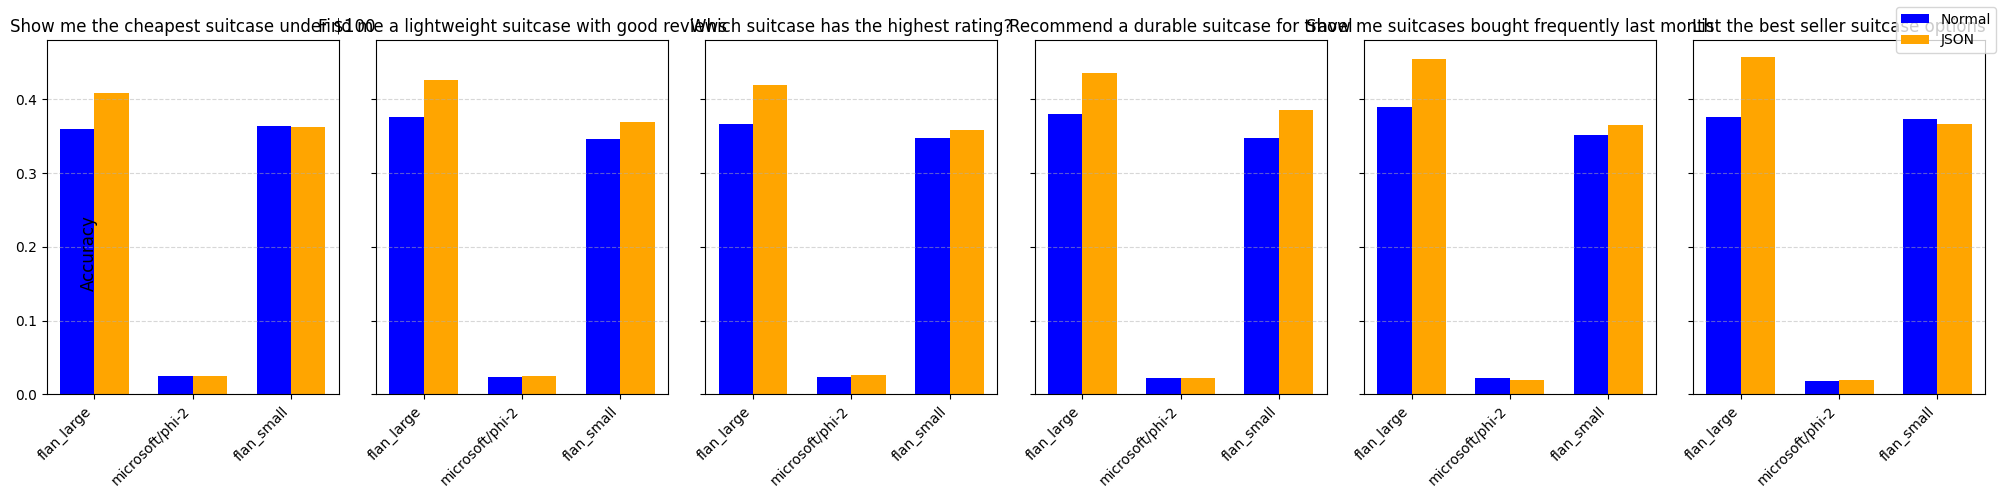

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

models = df_results["Model"].unique()
queries = df_results["Query"].unique()
colors = {"Normal":"blue", "JSON":"orange"}
width = 0.35  # width of individual bars

fig, axes = plt.subplots(1, len(queries), figsize=(20,5), sharey=True)

for i, query in enumerate(queries):
    ax = axes[i]
    data = df_results[df_results["Query"]==query].reset_index(drop=True)
    
    x = np.arange(len(data))  # positions for bars
    model_names = data["Model"]
    
    # Plot Normal bars
    ax.bar(x - width/2, data["Normal Accuracy"], width=width, color=colors["Normal"], label="Normal" if i==0 else "")
    
    # Plot JSON bars
    ax.bar(x + width/2, data["JSON Accuracy"], width=width, color=colors["JSON"], label="JSON" if i==0 else "")
    
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_title(query)
    ax.grid(axis="y", linestyle="--", alpha=0.5)


# Common y-label and legend
fig.text(0.04, 0.5, 'Accuracy', va='center', rotation='vertical', fontsize=12)
fig.legend(["Normal", "JSON"], loc='upper right')
plt.tight_layout()
plt.show()
